In [1]:
!pip install yfinance ta tensorflow scikit-learn


  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=a3a8ae6f836ec677aef3c893e83846bdf5a1df839f60163adcd0627022bfa986
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from ta.momentum import RSIIndicator
from ta.trend import MACD, EMAIndicator
import matplotlib.pyplot as plt


In [13]:
def fetch_stock_data(ticker, period="6mo", interval="1d"):
    df = yf.download(ticker, period=period, interval=interval)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)  # flatten MultiIndex
    df.dropna(inplace=True)
    return df


In [14]:
def add_technical_indicators(df):
    df['RSI'] = RSIIndicator(close=df['Close']).rsi()
    df['MACD'] = MACD(close=df['Close']).macd()
    df['EMA20'] = EMAIndicator(close=df['Close'], window=20).ema_indicator()
    return df.dropna()
    print(df.head())
print(df.shape)
print(df.columns)

(123, 5)
MultiIndex([( 'Close', 'AAPL'),
            (  'High', 'AAPL'),
            (   'Low', 'AAPL'),
            (  'Open', 'AAPL'),
            ('Volume', 'AAPL')],
           names=['Price', 'Ticker'])


In [15]:
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i - seq_length:i])
        y.append(data[i])
    return np.array(X), np.array(y)

def scale_data(df, feature='Close'):
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[[feature]])
    return scaled, scaler


In [16]:
def build_lstm(input_shape):
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model


In [17]:

ticker = "AAPL"
df = fetch_stock_data(ticker)
df = add_technical_indicators(df)


scaled_close, scaler = scale_data(df)
X, y = create_sequences(scaled_close)


X = X.reshape((X.shape[0], X.shape[1], 1))


model = build_lstm((X.shape[1], 1))
model.fit(X, y, epochs=10, batch_size=32)


last_seq = scaled_close[-60:]
last_seq = last_seq.reshape((1, 60, 1))
predicted_scaled = model.predict(last_seq)
predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

print(f"📈 Predicted Next Close Price for {ticker}: ${predicted_price:.2f}")


/tmp/ipython-input-13-1232428605.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, period=period, interval=interval)
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.1842
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0987 
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0353
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0062
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0212
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0229
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0094 
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0047
Epoch 9/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0063
Epoch 10/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.0092
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
📈 Predicted Next Close Price for AAPL: $194.50


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 


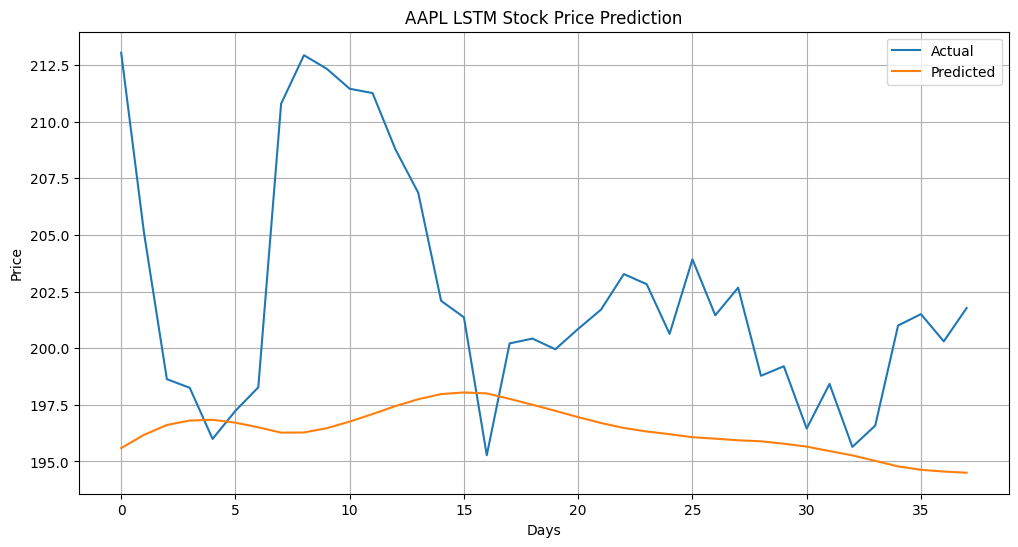

In [18]:
predicted_full = model.predict(X)
actual_rescaled = scaler.inverse_transform(y.reshape(-1, 1))
predicted_rescaled = scaler.inverse_transform(predicted_full)

plt.figure(figsize=(12,6))
plt.plot(actual_rescaled, label='Actual')
plt.plot(predicted_rescaled, label='Predicted')
plt.title(f'{ticker} LSTM Stock Price Prediction')
plt.xlabel('Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()


In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(actual_rescaled, predicted_rescaled))
mae = mean_absolute_error(actual_rescaled, predicted_rescaled)
r2 = r2_score(actual_rescaled, predicted_rescaled)

print(f"📉 RMSE: {rmse:.2f}")
print(f"📉 MAE: {mae:.2f}")
print(f"📈 R² Score: {r2:.4f}")


📉 RMSE: 7.79
📉 MAE: 6.11
📈 R² Score: -1.3658
